In [18]:
from matplotlib import pyplot as plt 
import numpy as np 
import pickle as pkl
import os
from scipy.stats import spearmanr
import pandas as pd
from sklearn.metrics import roc_auc_score
from scipy.stats import spearmanr
import statsmodels.api as sm

import sys 
sys.path.append('../src/')
from utils import load_config, get_corruption_scores

# Load results

In [34]:
out_dir = '../results/exp7'

res = pd.read_csv(f'{out_dir}/results.csv', sep='\t')
res.head()

,uid,config,config-checksum,method,perf_filter_low,perf_filter_high,runtime_s
0,028d6748-61f0-439e-9d64-7be2aa4ed4f5,../configs/exp7.py,a61710123bbd2701a521f26a500ff9cc,dvgs,"[0.9065681266775638, 0.9047738737298385, 0.904...","[0.9064476114448936, 0.9064613224472475, 0.886...",8389.136718


In [35]:
vals_dict = {uid:
                {
                 'vals':np.load(f'{out_dir}/data_values/{uid}/data_values.npy'), 
                 'exog':np.load(f'{out_dir}/data_values/{uid}/exog_noise.npy'),
                 'endog':np.load(f'{out_dir}/data_values/{uid}/endog_noise.npy')
                } 
            for uid in res.uid.values}

In [36]:
# check that all config-checksums are identical; if not, it may have changed between runs 
if res['config-checksum'].unique().shape[0] > 1: 
    print('WARNING! config checksums are not identical, config file may have changed between runs.')

# check that the same config file was used 
if res['config'].unique().shape[0] > 1: 
    print('WARNING! Different config. files were used between runs.')

In [37]:
config = load_config(res.config[0])

Using cache found in /home/teddy/.cache/torch/hub/pytorch_vision_v0.10.0


# corrupted label identification 

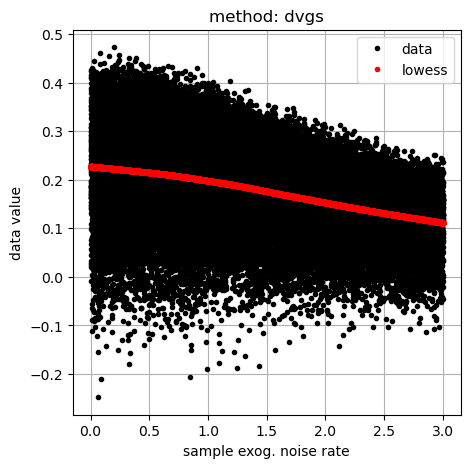

In [38]:
spearman_corr = {m:[] for m in res.method.unique()}

for method, c in zip(res.method.unique(), ['r', 'g', 'b', 'm', 'c']): 

    _temp = res[lambda x: x.method == method]
    
    pp_corr = []
    for i,row in _temp.iterrows(): 

        exog_noise = vals_dict[row.uid]['exog']
        vals = vals_dict[row.uid]['vals']

        spearman_corr[method].append(spearmanr(exog_noise, vals)[0])

        lowess = sm.nonparametric.lowess
        lowess_fit = lowess(vals.ravel(), np.array(exog_noise).ravel(), return_sorted=False, frac=0.4)

        plt.figure(figsize=(5, 5))
        plt.plot(exog_noise, vals, "k.", label='data')
        plt.plot(exog_noise, lowess_fit, "r.", label='lowess')
        plt.xlabel('sample exog. noise rate')
        plt.ylabel('data value')
        plt.title(f'method: {method}')
        plt.grid(b=None)
        plt.legend()
        plt.show()


In [39]:
table_latex = [[config.dataset]]
for method in ['dvgs', 'dshap', 'dvrl', 'loo', 'random']: 
    if method in spearman_corr: 
        table_latex.append( [f'{np.mean(spearman_corr[method]):.3f} $\pm$ {2*np.std(spearman_corr[method]):.3f}'] )
    else: 
        table_latex.append(['NA'])

table_latex = pd.DataFrame(table_latex).T 
table_latex.columns= ['Dataset', 'dvgs', 'dshap', 'dvrl', 'loo', 'random']

print()
table_latex.style.to_latex()

'\\begin{tabular}{lllllll}\n & Dataset & dvgs & dshap & dvrl & loo & random \\\\\n0 & cifar10-unsupervised & -0.372 $\\pm$ 0.000 & NA & NA & NA & NA \\\\\n\\end{tabular}\n'

In [40]:
table_latex

,Dataset,dvgs,dshap,dvrl,loo,random
0,cifar10-unsupervised,-0.372 $\pm$ 0.000,NA,NA,NA,NA


# Filtered Data Performance

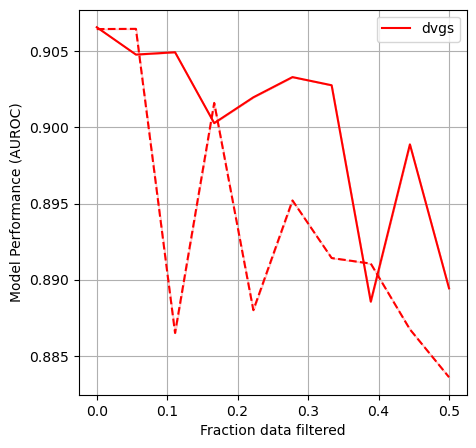

In [42]:
plt.figure(figsize=(5, 5))

for method, c in zip(res.method.unique(), ['r', 'g', 'b', 'm', 'c']): 

    _temp = res[lambda x: x.method == method]
    
    _low = [] 
    _high = [] 
    for i,row in _temp.iterrows(): 
        _low.append(row.perf_filter_low.strip('[]').split(','))
        _high.append(row.perf_filter_high.strip('[]').split(','))

    _low = np.stack(_low, axis=0).astype(float)
    _high = np.stack(_high, axis=0).astype(float)

    plt.plot(config.filter_kwargs['qs'], _low.mean(axis=0), color=c, label=method, linestyle='-')
    plt.fill_between(config.filter_kwargs['qs'], (_low.mean(axis=0)-_low.std(axis=0)), (_low.mean(axis=0)+_low.std(axis=0)), color=c, alpha=.2)

    plt.plot(config.filter_kwargs['qs'], _high.mean(axis=0), color=c, linestyle='--')
    plt.fill_between(config.filter_kwargs['qs'], (_high.mean(axis=0)-_high.std(axis=0)), (_high.mean(axis=0)+_high.std(axis=0)), color=c, alpha=.2)

plt.legend()
plt.xlabel('Fraction data filtered')
plt.ylabel('Model Performance (AUROC)')
plt.grid(b=None)
plt.show()